In [1]:
import os
import json
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Construct the base path relative to the current working directory
base_path = os.path.join(os.getcwd(), '..', '..', 'Data', 'CVE', 'cves')

data = []

# Traverse the directory tree
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.json'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                cve_data = json.load(f)
                if isinstance(cve_data, dict):
                    cveId = cve_data.get('cveMetadata', {}).get('cveId')
                    shortName = cve_data.get('cveMetadata', {}).get('assignerShortName')
                    datePublished = cve_data.get('cveMetadata', {}).get('datePublished')
                    data.append({
                        'cveId': cveId,
                        'shortName': shortName,
                        'datePublished': datePublished
                    })

# Create DataFrame
cve_df = pd.DataFrame(data)

# Rename columns
cve_df.rename(columns={
    'cveId': 'CVE',
    'shortName': 'CNA',
    'datePublished': 'Date'
}, inplace=True)

# Convert 'Date' using regex
cve_df['Date'] = cve_df['Date'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group(0) if pd.notna(x) else None)

# Convert 'Date' to datetime
cve_df['Date'] = pd.to_datetime(cve_df['Date'], errors='coerce')

# Drop rows with NaT values in the Date column after conversion 
cve_df = cve_df.dropna(subset=['Date'])

# Capitalize the CNA names
cve_df['CNA'] = cve_df['CNA'].str.capitalize()

# Display the DataFrame
cve_df

,CVE,CNA,Date
1,CVE-2013-2824,Icscert,2014-02-26
2,CVE-2013-2127,Redhat,2013-08-14
3,CVE-2013-2577,Mitre,2013-08-09
4,CVE-2013-2598,Mitre,2014-08-31
5,CVE-2013-2062,Redhat,2013-06-15
...,...,...,...
284367,CVE-2004-1419,Mitre,2005-02-12
284368,CVE-2004-1675,Mitre,2005-02-20
284369,CVE-2004-1225,Mitre,2004-12-15
284370,CVE-2004-1730,Mitre,2005-02-26


In [3]:
# Get today's date
today = pd.Timestamp.today()

# Calculate the date one year ago from today
one_year_ago = today - pd.DateOffset(years=1)

# Filter the DataFrame for CVEs from the last year
last_year_cves = cve_df[cve_df['Date'] >= one_year_ago]

# Display the filtered DataFrame
last_year_cves

,CVE,CNA,Date
13133,CVE-2014-125110,Vuldb,2024-03-31
13149,CVE-2014-125111,Vuldb,2024-04-08
14874,CVE-2014-5470,Mitre,2024-06-21
15844,CVE-2022-2440,Wordfence,2024-08-29
16028,CVE-2022-2446,Wordfence,2024-09-13
...,...,...,...
265586,CVE-2016-20022,Mitre,2024-06-27
266647,CVE-2016-10408,Qualcomm,2024-11-26
266892,CVE-2016-10394,Qualcomm,2024-11-26
274894,CVE-2005-10003,Vuldb,2024-10-17


In [4]:
# Get today's date
today = pd.Timestamp.today()

# Calculate the date one year ago from today
one_year_ago = today - pd.DateOffset(years=1)

# Filter the DataFrame for CVEs from the last year
last_year_cves = cve_df[cve_df['Date'] >= one_year_ago]

# Calculate the total number of days in the period
total_days = (today - one_year_ago).days

# Calculate the total number of CVEs each CNA published in the last year
cna_total_cves = last_year_cves.groupby('CNA').size().reset_index(name='Total_CVEs')

# Add the total number of days to the DataFrame
cna_total_cves['Total_Days'] = total_days

# Calculate the average number of CVEs per day for each CNA
cna_total_cves['Average_CVEs_per_day'] = cna_total_cves['Total_CVEs'] / cna_total_cves['Total_Days']

# Sort the DataFrame by 'Average_CVEs_per_day' in descending order
cna_total_cves = cna_total_cves.sort_values(by='Average_CVEs_per_day', ascending=False)

# Display the DataFrame
cna_total_cves

,CNA,Total_CVEs,Total_Days,Average_CVEs_per_day
167,Mitre,6106,365,16.728767
209,Patchstack,5893,365,16.145205
155,Linux,5234,365,14.339726
296,Wordfence,4043,365,11.076712
288,Vuldb,2983,365,8.172603
...,...,...,...,...
174,Ncsc-fi,1,365,0.002740
148,Krcert,1,365,0.002740
146,Knime,1,365,0.002740
130,Ict,1,365,0.002740


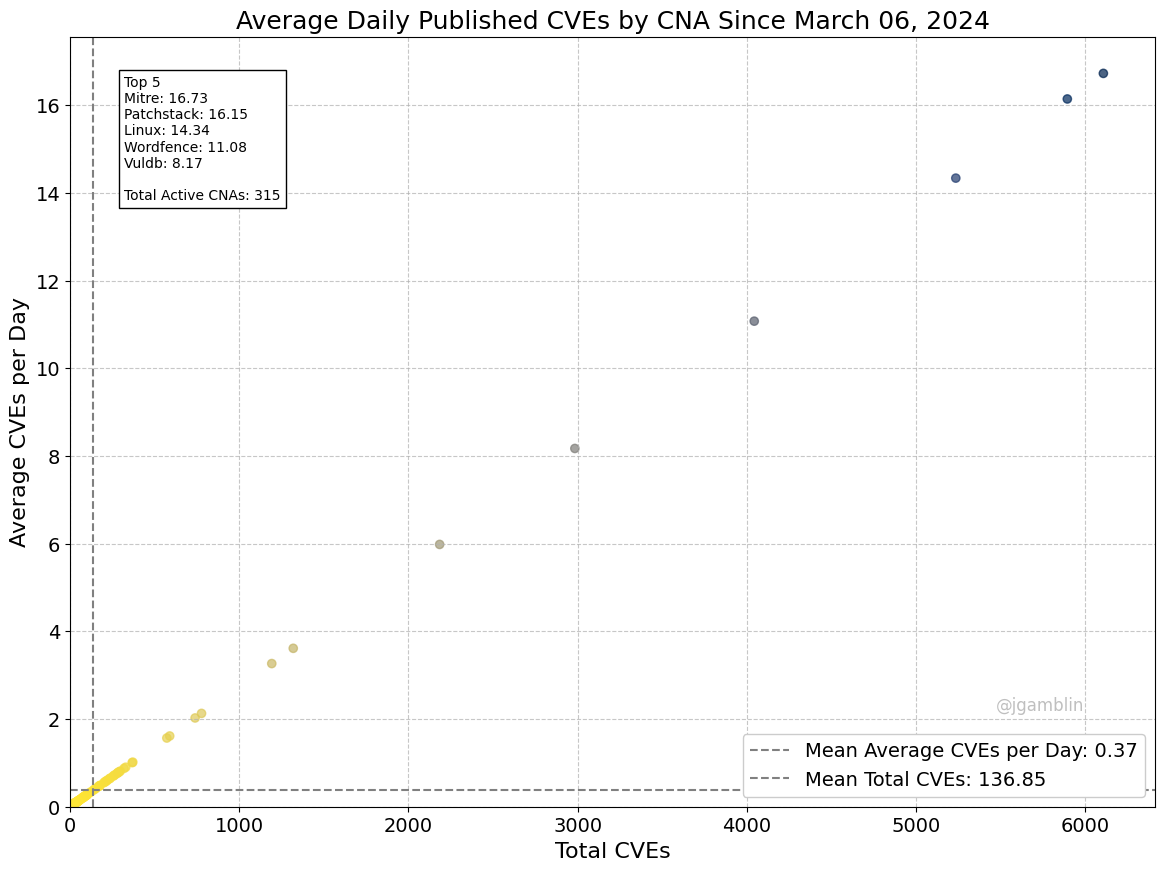

In [5]:
# Set the font family to 'DejaVu Sans'
plt.rcParams['font.family'] = 'DejaVu Sans'

# Calculate the mean of 'Average_CVEs_per_day' and 'Total_CVEs'
mean_average_cves_per_day = cna_total_cves['Average_CVEs_per_day'].mean()
mean_total_cves = cna_total_cves['Total_CVEs'].mean()

# Get the date one year ago and format it as "Month Day, Year"
one_year_ago_str = one_year_ago.strftime('%B %d, %Y')

# Calculate the total number of active CNAs
total_active_cnas = cna_total_cves['CNA'].nunique()

# Create a scatter plot of 'Total_CVEs' vs 'Average_CVEs_per_day' with a colormap
plt.figure(figsize=(14, 10))
scatter = plt.scatter(cna_total_cves['Total_CVEs'], cna_total_cves['Average_CVEs_per_day'], 
                      c=cna_total_cves['Average_CVEs_per_day'], cmap='cividis_r', alpha=0.7)

# Add a horizontal line for the mean of 'Average_CVEs_per_day'
plt.axhline(y=mean_average_cves_per_day, color='grey', linestyle='--', label=f'Mean Average CVEs per Day: {mean_average_cves_per_day:.2f}')

# Add a vertical line for the mean of 'Total_CVEs'
plt.axvline(x=mean_total_cves, color='grey', linestyle='--', label=f'Mean Total CVEs: {mean_total_cves:.2f}')

# Add labels and title with increased font size
plt.xlabel('Total CVEs', fontsize=16)
plt.ylabel('Average CVEs per Day', fontsize=16)
plt.title(f'Average Daily Published CVEs by CNA Since {one_year_ago_str}', fontsize=18)

# Set axis limits to start from 0,0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add grid with a lighter color
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend with a border, move it to the bottom right, and make it opaque
plt.legend(frameon=True, fontsize=14, loc='lower right', framealpha=1.0)

# Increase the font size of the ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Get the top five CNAs by 'Average_CVEs_per_day'
top_five_cnas = cna_total_cves.nlargest(5, 'Average_CVEs_per_day')

# Create a list of the top five CNAs with their average CVEs per day
top_five_list = [f"{row.CNA}: {row.Average_CVEs_per_day:.2f}" for row in top_five_cnas.itertuples()]

# Add the list to the upper left-hand corner of the plot
ranking_text = f"Top 5\n" + "\n".join(top_five_list) + f"\n\nTotal Active CNAs: {total_active_cnas}"
plt.text(0.05, 0.95, ranking_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=1.0))

# Add a watermark
plt.text(0.935, 0.12, '@jgamblin', fontsize=12, color='grey', ha='right', va='bottom', alpha=0.5, transform=plt.gca().transAxes)

# Save the plot as a PNG file
plt.savefig('average_daily_published_cves_by_cna.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

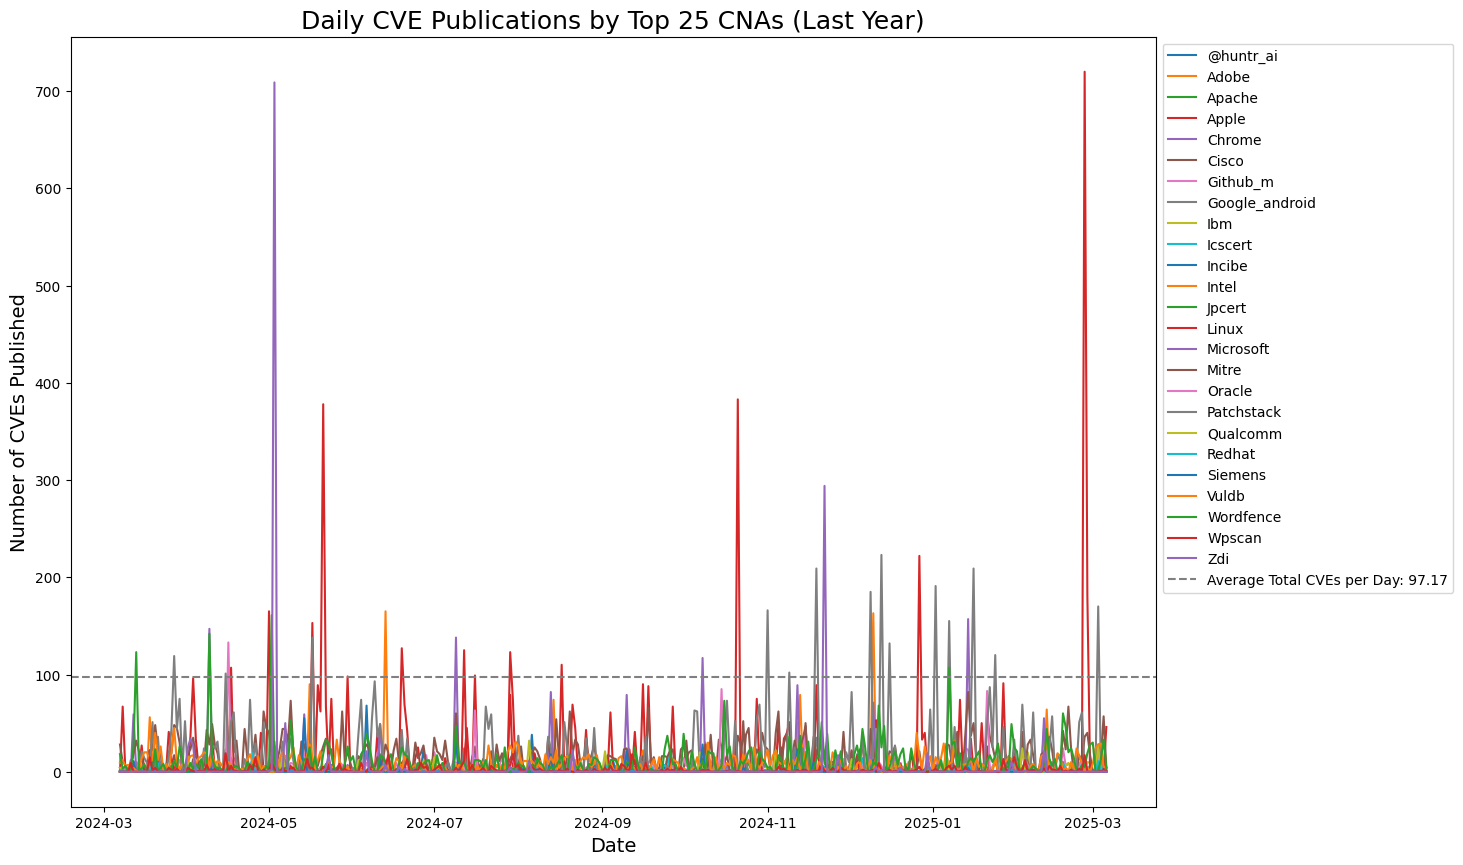

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming last_year_cves is the DataFrame containing the CVE data for the last year with columns 'CNA' and 'Date'

# Aggregate the number of CVEs published by each CNA on a daily basis
daily_cve_counts = last_year_cves.groupby(['CNA', 'Date']).size().reset_index(name='CVEs_per_day')

# Calculate the total number of CVEs published by each CNA
total_cves_per_cna = daily_cve_counts.groupby('CNA')['CVEs_per_day'].sum().reset_index()

# Get the top 25 CNAs by total number of CVEs published
top_25_cnas = total_cves_per_cna.nlargest(25, 'CVEs_per_day')['CNA']

# Filter the daily_cve_counts DataFrame to include only the top 25 CNAs
filtered_daily_cve_counts = daily_cve_counts[daily_cve_counts['CNA'].isin(top_25_cnas)]

# Pivot the data to have CNAs as columns and dates as rows
pivot_df = filtered_daily_cve_counts.pivot(index='Date', columns='CNA', values='CVEs_per_day').fillna(0)

# Calculate the average total number of CVEs published per day
average_total_cves_per_day = pivot_df.sum(axis=1).mean()

# Plot the time series for each of the top 25 CNAs
plt.figure(figsize=(14, 10))
for cna in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[cna], label=cna)

# Add a dotted grey line for the average total CVEs published per day
plt.axhline(y=average_total_cves_per_day, color='grey', linestyle='--', label=f'Average Total CVEs per Day: {average_total_cves_per_day:.2f}')

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of CVEs Published', fontsize=14)
plt.title('Daily CVE Publications by Top 25 CNAs (Last Year)', fontsize=18)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Display the plot
plt.show()

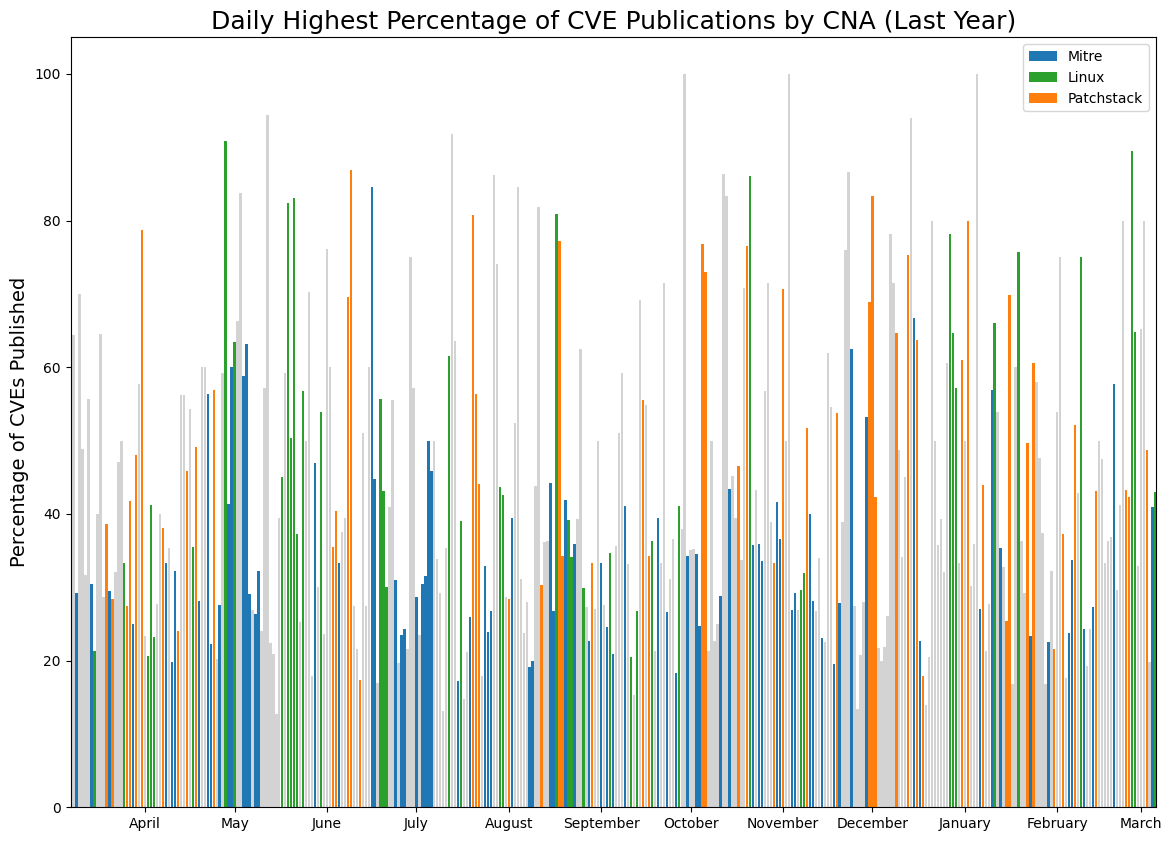

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming last_year_cves is the DataFrame containing the CVE data for the last year with columns 'CNA' and 'Date'

# Aggregate the number of CVEs published by each CNA on a daily basis
daily_cve_counts = last_year_cves.groupby(['CNA', 'Date']).size().reset_index(name='CVEs_per_day')

# Calculate the total number of CVEs published each day
total_cves_per_day = daily_cve_counts.groupby('Date')['CVEs_per_day'].sum().reset_index(name='Total_CVEs_per_day')

# Merge the total CVEs per day with the daily CVE counts
merged_df = pd.merge(daily_cve_counts, total_cves_per_day, on='Date')

# Calculate the percentage of CVEs each CNA published each day
merged_df['Percentage_CVEs_per_day'] = (merged_df['CVEs_per_day'] / merged_df['Total_CVEs_per_day']) * 100

# Find the CNA with the highest percentage of CVEs published each day
idx = merged_df.groupby(['Date'])['Percentage_CVEs_per_day'].idxmax()
highest_percentage_df = merged_df.loc[idx]

# Plot the bar graph for the CNA with the highest percentage each day
plt.figure(figsize=(14, 10))

# Set colors for CNAs
cna_colors = {'Mitre': '#1f77b4', 'Linux': '#2ca02c', 'Patchstack': '#ff7f0e'}
for cna in highest_percentage_df['CNA'].unique():
    if cna not in cna_colors:
        cna_colors[cna] = 'lightgrey'

# Plot the bars
for cna in highest_percentage_df['CNA'].unique():
    cna_data = highest_percentage_df[highest_percentage_df['CNA'] == cna]
    for date, percentage in zip(cna_data['Date'], cna_data['Percentage_CVEs_per_day']):
        if percentage >= 5:
            plt.bar(date, percentage, color=cna_colors[cna], label=cna)
        else:
            plt.bar(date, percentage, color='lightgrey')

# Add labels and title
plt.ylabel('Percentage of CVEs Published', fontsize=14)
plt.title('Daily Highest Percentage of CVE Publications by CNA (Last Year)', fontsize=18)

# Format x-axis to show month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Set x-axis limits to start from the first date in the data
plt.xlim([merged_df['Date'].min(), merged_df['Date'].max()])

# Add legend, excluding light grey CNAs and deduplicating
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if cna_colors.get(l, 'lightgrey') != 'lightgrey']
unique_labels = {}
for handle, label in filtered_handles_labels:
    if label not in unique_labels:
        unique_labels[label] = handle
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize=10)

# Save the plot as a PNG file
plt.savefig('daily_highest_percentage_cve_publications.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

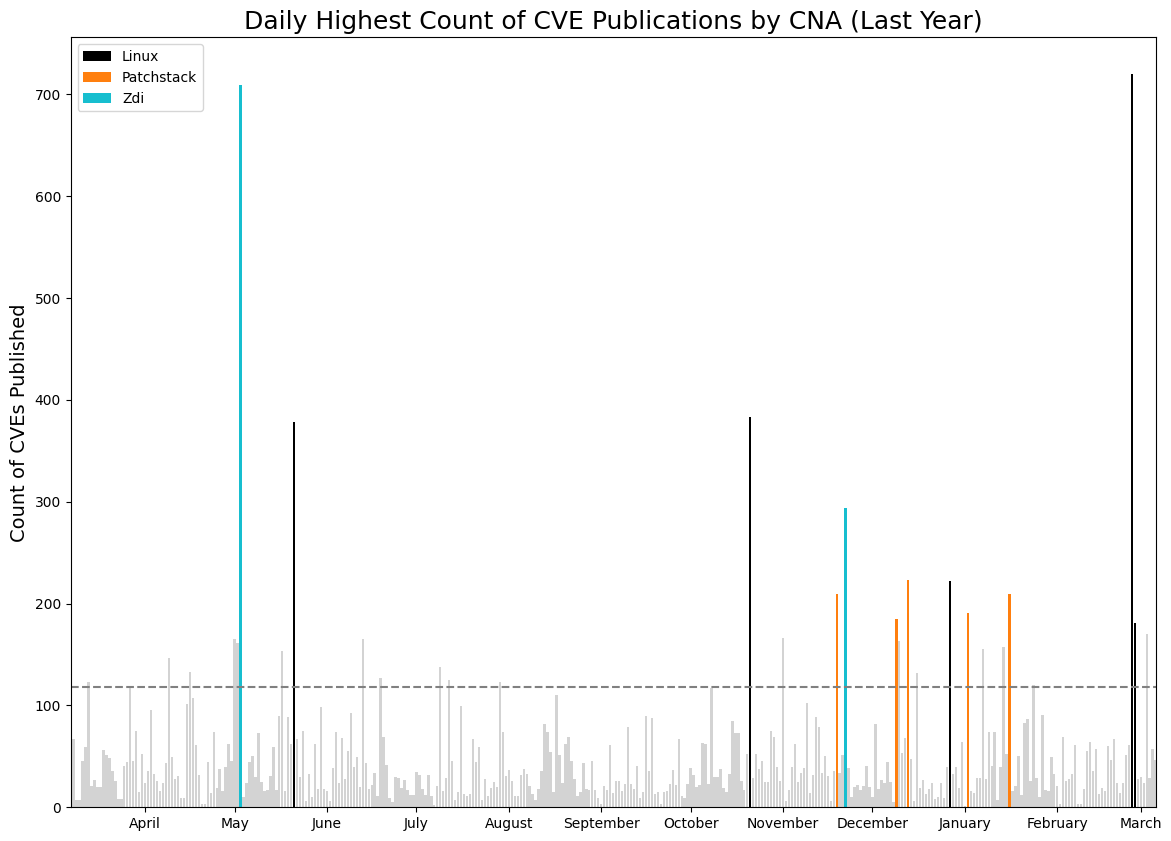

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Aggregate the number of CVEs published by each CNA on a daily basis
daily_cve_counts = last_year_cves.groupby(['CNA', 'Date']).size().reset_index(name='CVEs_per_day')

# Calculate the total number of CVEs published each day
total_cves_per_day = daily_cve_counts.groupby('Date')['CVEs_per_day'].sum().reset_index(name='Total_CVEs_per_day')

# Find the CNA with the highest count of CVEs published each day
idx = daily_cve_counts.groupby(['Date'])['CVEs_per_day'].idxmax()
highest_count_df = daily_cve_counts.loc[idx]

# Calculate the average number of CVEs published per day across all CNAs
average_cves_per_day = total_cves_per_day['Total_CVEs_per_day'].mean()

# Define the threshold as 150% of the daily average
threshold = 1.5 * average_cves_per_day

# Plot the bar graph for the CNA with the highest count each day
plt.figure(figsize=(14, 10))

# Set complementary colors for CNAs
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cna_colors = {}
for i, cna in enumerate(highest_count_df['CNA'].unique()):
    if cna == 'Linux':
        cna_colors[cna] = '#000000'  # Change the color for Linux to black
    elif cna == 'Patchstack':
        cna_colors[cna] = '#ff7f0e'  # Keep the color for Patchstack as orange
    else:
        cna_colors[cna] = colors[i % len(colors)]

# Plot the bars
for cna in highest_count_df['CNA'].unique():
    cna_data = highest_count_df[highest_count_df['CNA'] == cna]
    for date, count in zip(cna_data['Date'], cna_data['CVEs_per_day']):
        if count >= threshold:
            plt.bar(date, count, color=cna_colors[cna], label=cna)
        else:
            plt.bar(date, count, color='#d3d3d3')  # Use a lighter grey color

# Add a grey dashed line for the average number of CVEs published per day across all CNAs
plt.axhline(y=average_cves_per_day, color='grey', linestyle='--')

# Add labels and title
plt.ylabel('Count of CVEs Published', fontsize=14)
plt.title('Daily Highest Count of CVE Publications by CNA (Last Year)', fontsize=18)

# Format x-axis to show month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Set x-axis limits to start from the first date in the data
plt.xlim([daily_cve_counts['Date'].min(), daily_cve_counts['Date'].max()])

# Add legend, including only CNAs with bars above the threshold and deduplicating
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in cna_colors and any(highest_count_df[highest_count_df['CNA'] == l]['CVEs_per_day'] >= threshold)]
unique_labels = {}
for handle, label in filtered_handles_labels:
    if label not in unique_labels:
        unique_labels[label] = handle
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', fontsize=10)

# Save the plot as a PNG file
plt.savefig('daily_highest_count_cve_publications.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

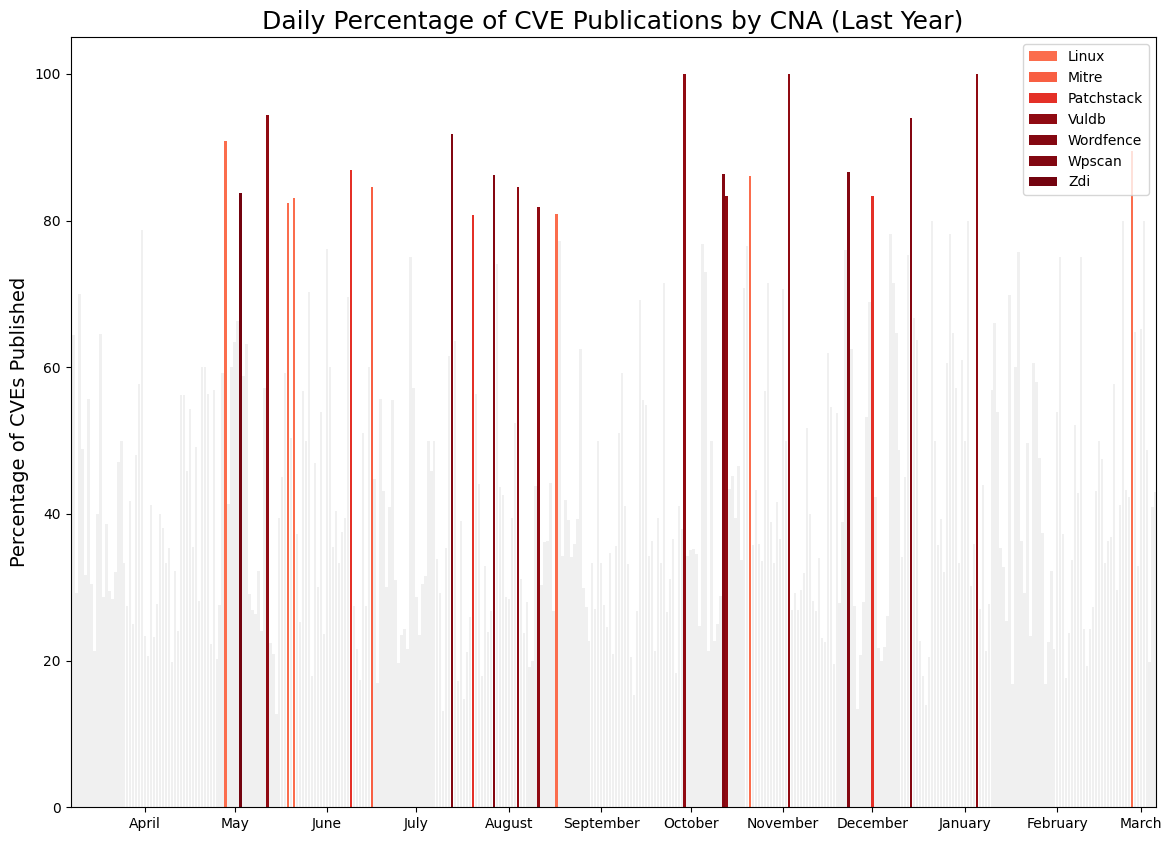

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming last_year_cves is the DataFrame containing the CVE data for the last year with columns 'CNA' and 'Date'

# Aggregate the number of CVEs published by each CNA on a daily basis
daily_cve_counts = last_year_cves.groupby(['CNA', 'Date']).size().reset_index(name='CVEs_per_day')

# Calculate the total number of CVEs published each day
total_cves_per_day = daily_cve_counts.groupby('Date')['CVEs_per_day'].sum().reset_index(name='Total_CVEs_per_day')

# Merge the total CVEs per day with the daily CVE counts
merged_df = pd.merge(daily_cve_counts, total_cves_per_day, on='Date')

# Calculate the percentage of CVEs each CNA published each day
merged_df['Percentage_CVEs_per_day'] = (merged_df['CVEs_per_day'] / merged_df['Total_CVEs_per_day']) * 100

# Filter the DataFrame to include only CNAs who have published more than 80% of the CVEs for a day
filtered_df = merged_df[merged_df['Percentage_CVEs_per_day'] > 80]

# Plot the bar graph for all CNAs
plt.figure(figsize=(14, 10))

# Set colors for CNAs using a red colormap
colors = plt.cm.Reds  # Use the red colormap
cna_colors = {}
for i, cna in enumerate(merged_df['CNA'].unique()):
    cna_colors[cna] = colors(i / len(merged_df['CNA'].unique()))

# Plot the bars for all CNAs with super light color
for cna in merged_df['CNA'].unique():
    cna_data = merged_df[merged_df['CNA'] == cna]
    plt.bar(cna_data['Date'], cna_data['Percentage_CVEs_per_day'], color='#f0f0f0')  # Super light color

# Plot the bars for filtered CNAs with distinct colors
for cna in filtered_df['CNA'].unique():
    cna_data = filtered_df[filtered_df['CNA'] == cna]
    plt.bar(cna_data['Date'], cna_data['Percentage_CVEs_per_day'], color=cna_colors[cna], label=cna)

# Add labels and title
plt.ylabel('Percentage of CVEs Published', fontsize=14)
plt.title('Daily Percentage of CVE Publications by CNA (Last Year)', fontsize=18)

# Format x-axis to show month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Set x-axis limits to start from the first date in the data
plt.xlim([merged_df['Date'].min(), merged_df['Date'].max()])

# Add legend, including only CNAs with bars above the threshold and deduplicating
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in filtered_df['CNA'].unique()]
unique_labels = {}
for handle, label in filtered_handles_labels:
    if label not in unique_labels:
        unique_labels[label] = handle
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize=10)

# Save the plot as a PNG file
plt.savefig('daily_percentage_cve_publications_filtered_cnas.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()